<a href="https://colab.research.google.com/github/pravin2072/Company_bankruptcy_rediction/blob/main/Company_bankruptcy_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Importing Libraries**

In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
from random import randint
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score,accuracy_score, precision_score, recall_score, roc_auc_score 

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

import warnings
warnings.filterwarnings("ignore")

# **2. Loading the dataset**

In [1]:
#mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#loading the data file and creating a dataframe
import pandas as pd
path='/content/drive/MyDrive/COMPANY BANKRUPTCY PREDICTION_pravin2.csv' 
df=pd.read_csv(path)

# **3. Exploratory Data Analysis**

In [6]:
shape = df.shape
print("The dataframe has {} rows and {} columns".format(shape[0], shape[1]))

The dataframe has 6819 rows and 96 columns


In [7]:
#printing the dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Bankrupt?                                          6819 non-null   int64  
 1   ROA(C)beforeinterestanddepreciationbeforeinterest  6819 non-null   float64
 2   ROA(A)beforeinterestand%aftertax                   6819 non-null   float64
 3   ROA(B)beforeinterestanddepreciationaftertax        6819 non-null   float64
 4   OperatingGrossMargin                               6819 non-null   float64
 5   RealizedSalesGrossMargin                           6819 non-null   float64
 6   OperatingProfitRate                                6819 non-null   float64
 7   PretaxnetInterestRate                              6819 non-null   float64
 8   AftertaxnetInterestRate                            6819 non-null   float64
 9   Nonindus

In [8]:
#checking for duplicacy in the dataset
df.duplicated().sum()

0

**The dataset doesn't contain any duplicate rows**

In [9]:
df.isnull().sum().sort_values(ascending=False).head()

Bankrupt?                                            0
ROA(C)beforeinterestanddepreciationbeforeinterest    0
Totalexpense/Assets                                  0
Totalincome/Totalexpense                             0
RetainedEarningstoTotalAssets                        0
dtype: int64

**Since there are no missing values, we can jump into analyzing the data**

<Axes: xlabel='Bankrupt?', ylabel='count'>

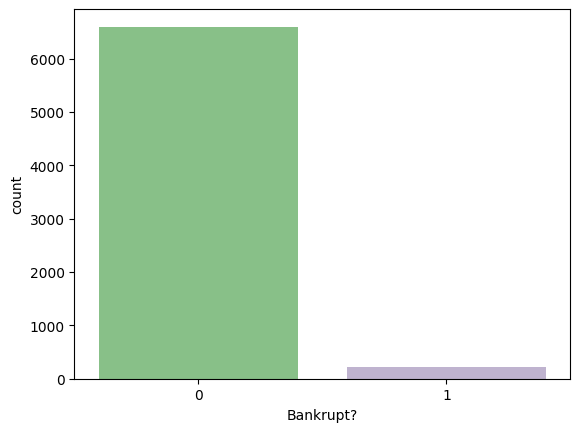

In [12]:
#finding number of bankrupt companies
import seaborn as sns
sns.countplot(x='Bankrupt?', data=df, palette='Accent')


The records are observed to be highly imbalanced. Thus it is necessary to consider balancing the dataset through "Upsampling or Downsampling" techniques.

Through df.info(), we observed that we have a majority of "float64" data. The categorical data is distinguished as binary 1 and 0, thus stored as "int64". We separate the numeric and categoric data to analyze our dataset.



In [13]:
numeric_features = df.dtypes[df.dtypes != 'int64'].index
categorical_features = df.dtypes[df.dtypes == 'int64'].index

df[categorical_features].columns.tolist()

['Bankrupt?', 'LiabilityAssetsFlag', 'NetIncomeFlag']

**There are only three categorical data columns, we will first explore these columns**

0    6811
1       8
Name: LiabilityAssetsFlag, dtype: int64


<Axes: xlabel='LiabilityAssetsFlag', ylabel='count'>

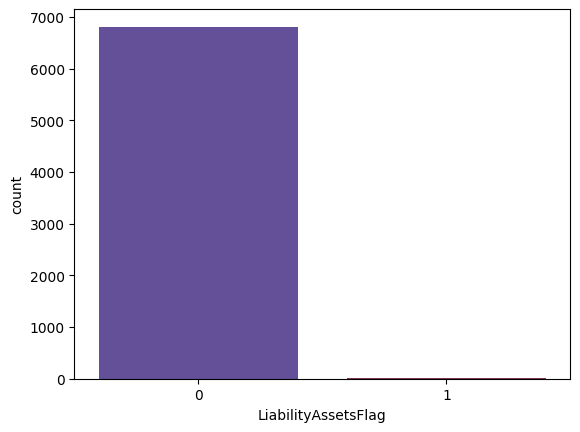

In [16]:
#Plotting count of liability-assets flag
print(df['LiabilityAssetsFlag'].value_counts())
sns.countplot(data=df, x='LiabilityAssetsFlag', palette='twilight')


**The "Liability-Assets" flag denotes the status of an organization, where if the total liability exceeds total assets, the flagged value will be 1, else the value is 0. A majority number of times, organizations/company's assets are more than their liabilities.**

LiabilityAssetsFlag  Bankrupt?
0                    0            6597
                     1             214
1                    1               6
                     0               2
dtype: int64


<Axes: xlabel='LiabilityAssetsFlag', ylabel='count'>

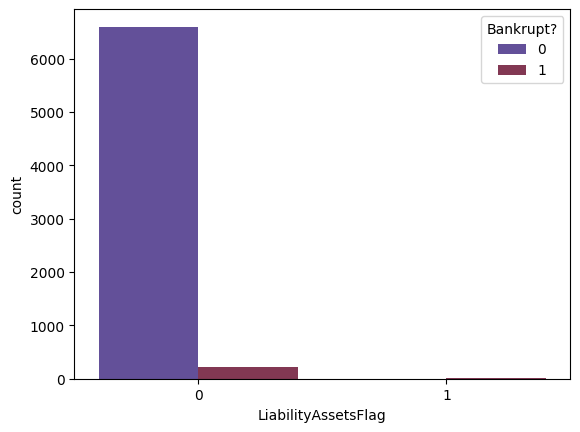

In [19]:
#Finding bankrupt companies on the basis of liability-assets flag
print(df[['LiabilityAssetsFlag','Bankrupt?']].value_counts())
sns.countplot(x = 'LiabilityAssetsFlag',hue = 'Bankrupt?',data = df,palette = 'twilight')

**A small portion of organizations suffers bankruptcy, although possessing more assets than their liabilities.**

1    6819
Name: NetIncomeFlag, dtype: int64


<Axes: xlabel='NetIncomeFlag', ylabel='count'>

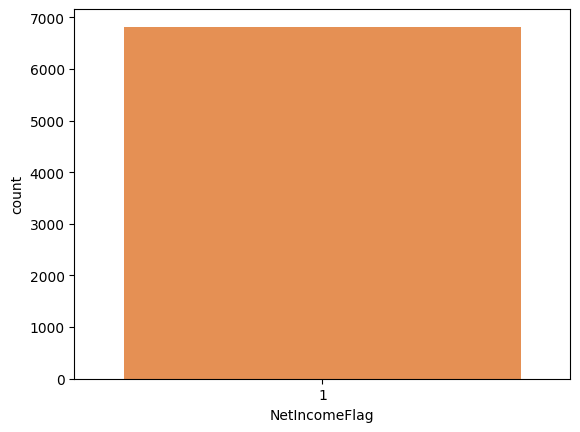

In [22]:
#Plotting total count of net income flag
print(df['NetIncomeFlag'].value_counts())
sns.countplot(x='NetIncomeFlag', data=df, palette='Oranges')

**The "Net Income" flag denotes the status of an organization's income in the last two years, where if the net income is negative for the past two years, the flagged value will be 1, else the value is 0. We observe that all the records have been exhibiting a loss for the past two years.**

NetIncomeFlag  Bankrupt?
1              0            6599
               1             220
dtype: int64


<Axes: xlabel='NetIncomeFlag', ylabel='count'>

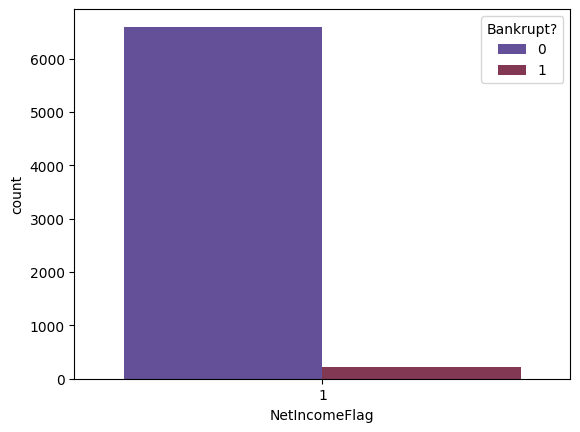

In [24]:
#Finding bankrupt companies on the basis of net income flag
print(df[['NetIncomeFlag','Bankrupt?']].value_counts())
sns.countplot(x = 'NetIncomeFlag',hue = 'Bankrupt?',data = df,palette = 'twilight')

**Many organizations that have suffered losses for the past two years have stabilized their business, thus avoiding bankruptcy.**

In [27]:
#For the sake of simplicity, we analyze the six top positively and negatively correlated attributes

positive_corr = df[numeric_features].corrwith(df["Bankrupt?"]).sort_values(ascending=False)[:6].index.tolist()
negative_corr = df[numeric_features].corrwith(df["Bankrupt?"]).sort_values()[:6].index.tolist()

positive_corr = df[positive_corr + ["Bankrupt?"]].copy()
negative_corr = df[negative_corr + ["Bankrupt?"]].copy()

In [37]:
def corrbargraph(x_value, y_value):
    
    plt.figure(figsize=(15,8))
    colors=['rainbow', 'RdBu_r']
    value = randint(0, len(colors)-1)

    for i in range(1,7):
        plt.subplot(2,3,i)  
        sns.barplot(x = x_value, y = y_value[i-1],data = df,palette = colors[value])

    plt.tight_layout(pad=0.5)


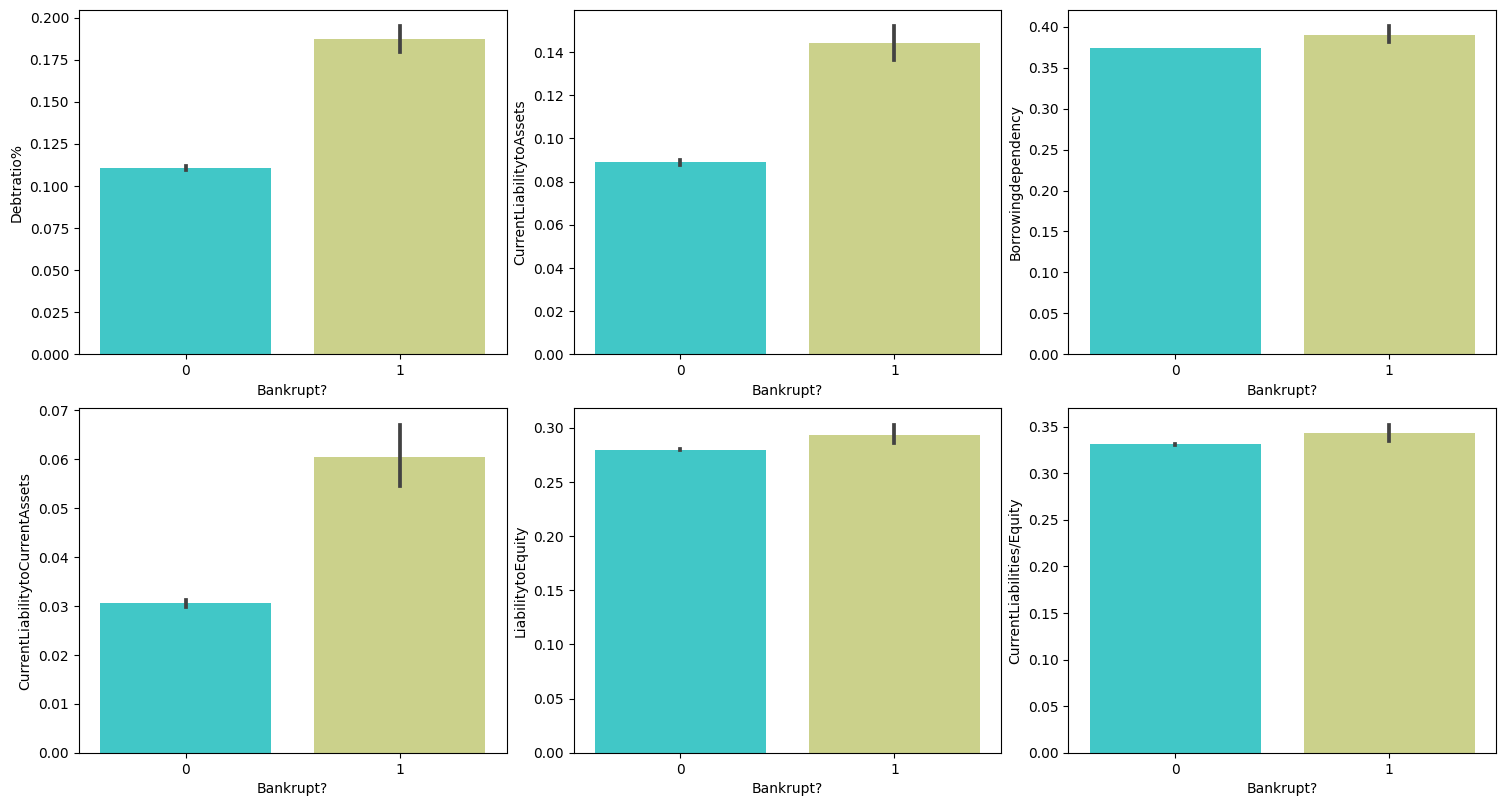

In [38]:
x_value = positive_corr.columns.tolist()[-1]
y_value = positive_corr.columns.tolist()[:-1]

corrbargraph(x_value, y_value)

**We see that three attributes - "Debt Ratio %, Current Liability To Assets, Current Liability To Current Assets" are commonly high in bankrupt organizations.**

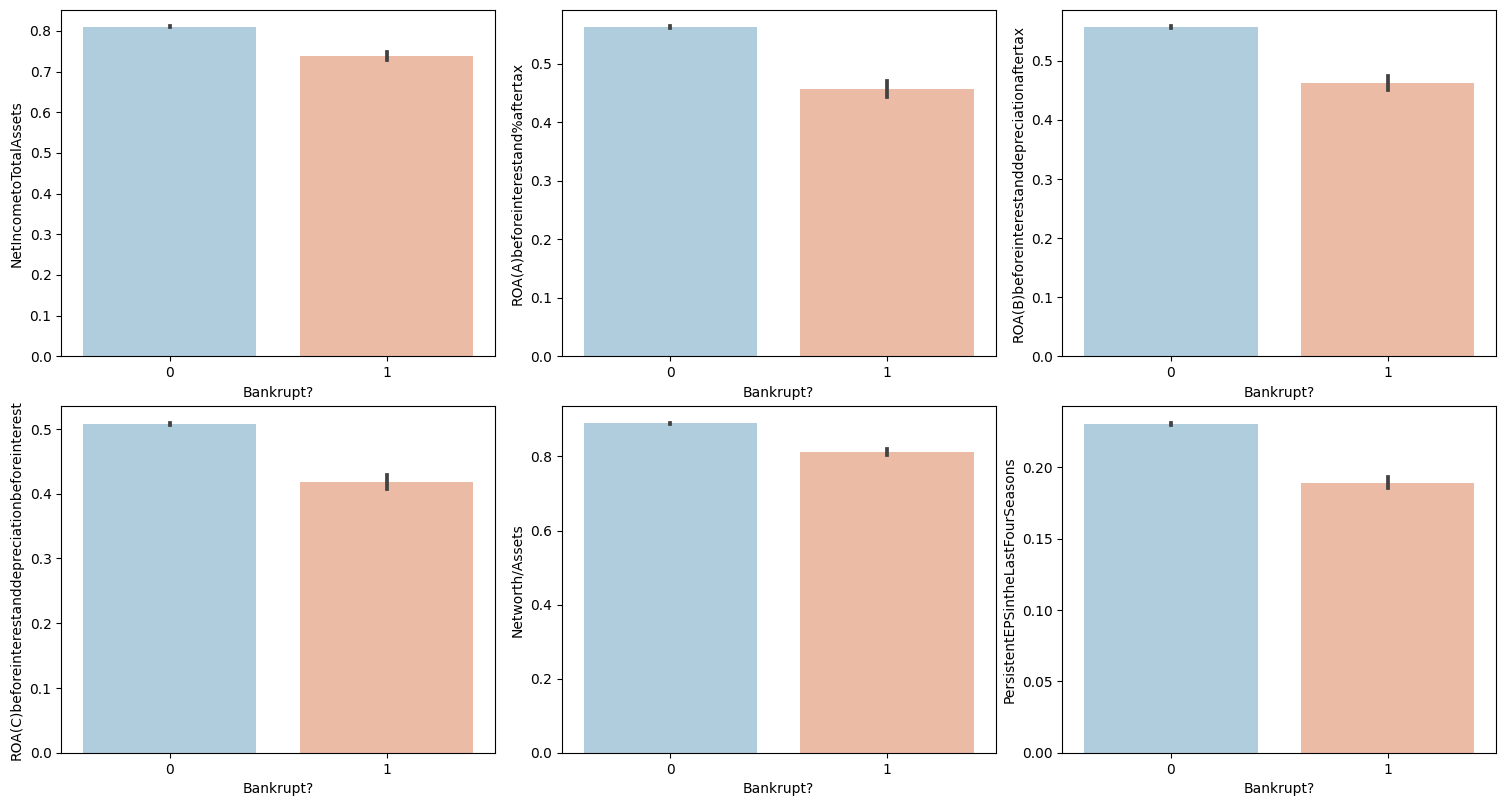

In [40]:
x_value = negative_corr.columns.tolist()[-1]
y_value = negative_corr.columns.tolist()[:-1]

corrbargraph(x_value, y_value)